Import Libraries

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score


import torch
from torch import nn


In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the dataset

In [45]:
train_path = "./Datasets/train.csv"
test_path = "./Datasets/test.csv"

mall_train_path = "./Datasets/mall_train.csv"
mall_test_path = "./Datasets/mall_test.csv"
mrt_train_path = "./Datasets/mrt-train.csv"
mrt_test_path = "./Datasets/mrt_test.csv"
school_train_path = "./Datasets/school_train.csv"
school_test_path = "./Datasets/school_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

mall_test = pd.read_csv(mall_test_path)
mall_train = pd.read_csv(mall_train_path)
mrt_train = pd.read_csv(mrt_train_path)
mrt_test = pd.read_csv(mrt_test_path)
school_train = pd.read_csv(school_train_path)
school_test = pd.read_csv(school_test_path)


In [46]:
mrt_columns = ['MRT_1km', 'nearest_MRT_dis', 'mrt_average_price']
train_data[mrt_columns] = mrt_train[mrt_columns]
test_data[mrt_columns] = mrt_test[mrt_columns]

school_columns = ['nearest_school_dis', 'nearest_school_name']
train_data[school_columns] = school_train[school_columns]
test_data[school_columns] = school_test[school_columns]

mall_columns = ['nearest_mall_dis', 'nearest_mall_name']
train_data[mall_columns] = mall_train[mall_columns]
test_data[mall_columns] = mall_test[mall_columns]

See train data distribution

In [47]:
train_data.shape

(60000, 23)

In [48]:
train_data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_dis,mrt_average_price,nearest_school_dis,nearest_school_name,nearest_mall_dis,nearest_mall_name
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,jurong east,west region,1600,1.0,0.200699,2481.346424,0.334495,Yuhua Primary School,1.197252,Westgate
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,...,bedok,east region,2250,1.0,0.000923,2425.980392,0.605547,St. Anthony's Canossian Primary School,1.114364,Djitsun Mall Bedok
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,...,toa payoh,central region,1900,4.0,0.518801,2632.947462,0.426187,CHIJ Primary (Toa Payoh),0.468813,HDB Hub
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,...,pasir ris,east region,2850,0.0,-0.647366,2687.550471,0.562392,Pasir Ris Primary School,0.400741,Loyang Point
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,...,kallang,central region,2100,3.0,0.487930,2589.985486,0.271506,Bendemeer Primary School,1.067395,Aperia


In [49]:
train_data.nunique()

rent_approval_date       31
town                     26
block                  2553
street_name            1083
flat_type                 9
flat_model               19
floor_area_sqm          146
furnished                 1
lease_commence_date      54
latitude               8612
longitude              8612
elevation                 1
subzone                 152
planning_area            29
region                    5
monthly_rent            113
MRT_1km                  15
nearest_MRT_dis        8630
mrt_average_price        96
nearest_school_dis     8612
nearest_school_name     164
nearest_mall_dis       8610
nearest_mall_name       114
dtype: int64

In [ ]:
train_data.isna().sum()

Data preprocessing of train_data

In [ ]:
def data_preprocessing(data):
    data.replace("-", " ", regex=True, inplace=True)

    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.lower()
    
    data['lease_commence_date'] = 2021 - data['lease_commence_date']

    def convert_to_numeric(date_str):
        year, month = date_str.split(" ")
        return float(year) + float(month)/12.0
    data['rent_approval_date'] = [convert_to_numeric(date) for date in data['rent_approval_date']]

    data['rent_approval_date'] = data['rent_approval_date'] - 2021
    
    # data = data.drop_duplicates()
    # data = data.reset_index(drop=True)
    # data['monthly_rent'] = np.log1p(data['monthly_rent'])
    # data.drop(data[(data['floor_area_sqm']<30)].index, inplace=True)
    # data.drop(data[(data['floor_area_sqm']>160)].index, inplace=True)
    # data.drop(data[(data['monthly_rent']>6000)].index, inplace=True)
    # data.drop(data[(data['monthly_rent']<500)].index, inplace=True)
    
    return data

train_data = data_preprocessing(train_data)
train_data
train_data.to_csv('train_data_clean.csv', index=False)


Feature Engineering of train_data

In [ ]:
X_train_num = train_data.select_dtypes(include = ['float64', 'int64'])
print(X_train_num.shape)
X_train_num.head()

(60000, 12)


,rent_approval_date,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent,MRT_1km,nearest_MRT_dis,mrt_average_price,nearest_school_dis,nearest_mall_dis
0,0.750000,67.0,38,1.344518,103.738630,0.0,1600,1.0,0.200699,2481.346424,0.334495,1.197252
1,1.416667,92.0,43,1.330186,103.938717,0.0,2250,1.0,0.000923,2425.980392,0.605547,1.114364
2,1.833333,67.0,50,1.332242,103.845643,0.0,1900,4.0,0.518801,2632.947462,0.426187,0.468813
3,0.666667,149.0,28,1.370239,103.962894,0.0,2850,0.0,-0.647366,2687.550471,0.562392,0.400741
4,1.916667,68.0,49,1.320502,103.863341,0.0,2100,3.0,0.487930,2589.985486,0.271506,1.067395


In [ ]:
X_train_cat = train_data.select_dtypes(include = ['object'])
print(X_train_cat.shape)
X_train_cat.head()

(60000, 11)


,town,block,street_name,flat_type,flat_model,furnished,subzone,planning_area,region,nearest_school_name,nearest_mall_name
0,jurong east,257,jurong east street 24,3 room,new generation,yes,yuhua east,jurong east,west region,yuhua primary school,westgate
1,bedok,119,bedok north road,4 room,new generation,yes,bedok north,bedok,east region,st. anthony's canossian primary school,djitsun mall bedok
2,toa payoh,157,lorong 1 toa payoh,3 room,improved,yes,toa payoh central,toa payoh,central region,chij primary (toa payoh),hdb hub
3,pasir ris,250,pasir ris street 21,executive,apartment,yes,pasir ris drive,pasir ris,east region,pasir ris primary school,loyang point
4,kallang/whampoa,34,whampoa west,3 room,improved,yes,bendemeer,kallang,central region,bendemeer primary school,aperia


array([[<AxesSubplot:title={'center':'rent_approval_date'}>,
        <AxesSubplot:title={'center':'floor_area_sqm'}>,
        <AxesSubplot:title={'center':'lease_commence_date'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'elevation'}>],
       [<AxesSubplot:title={'center':'monthly_rent'}>,
        <AxesSubplot:title={'center':'MRT_1km'}>,
        <AxesSubplot:title={'center':'nearest_MRT_dis'}>],
       [<AxesSubplot:title={'center':'mrt_average_price'}>,
        <AxesSubplot:title={'center':'nearest_school_dis'}>,
        <AxesSubplot:title={'center':'nearest_mall_dis'}>]], dtype=object)

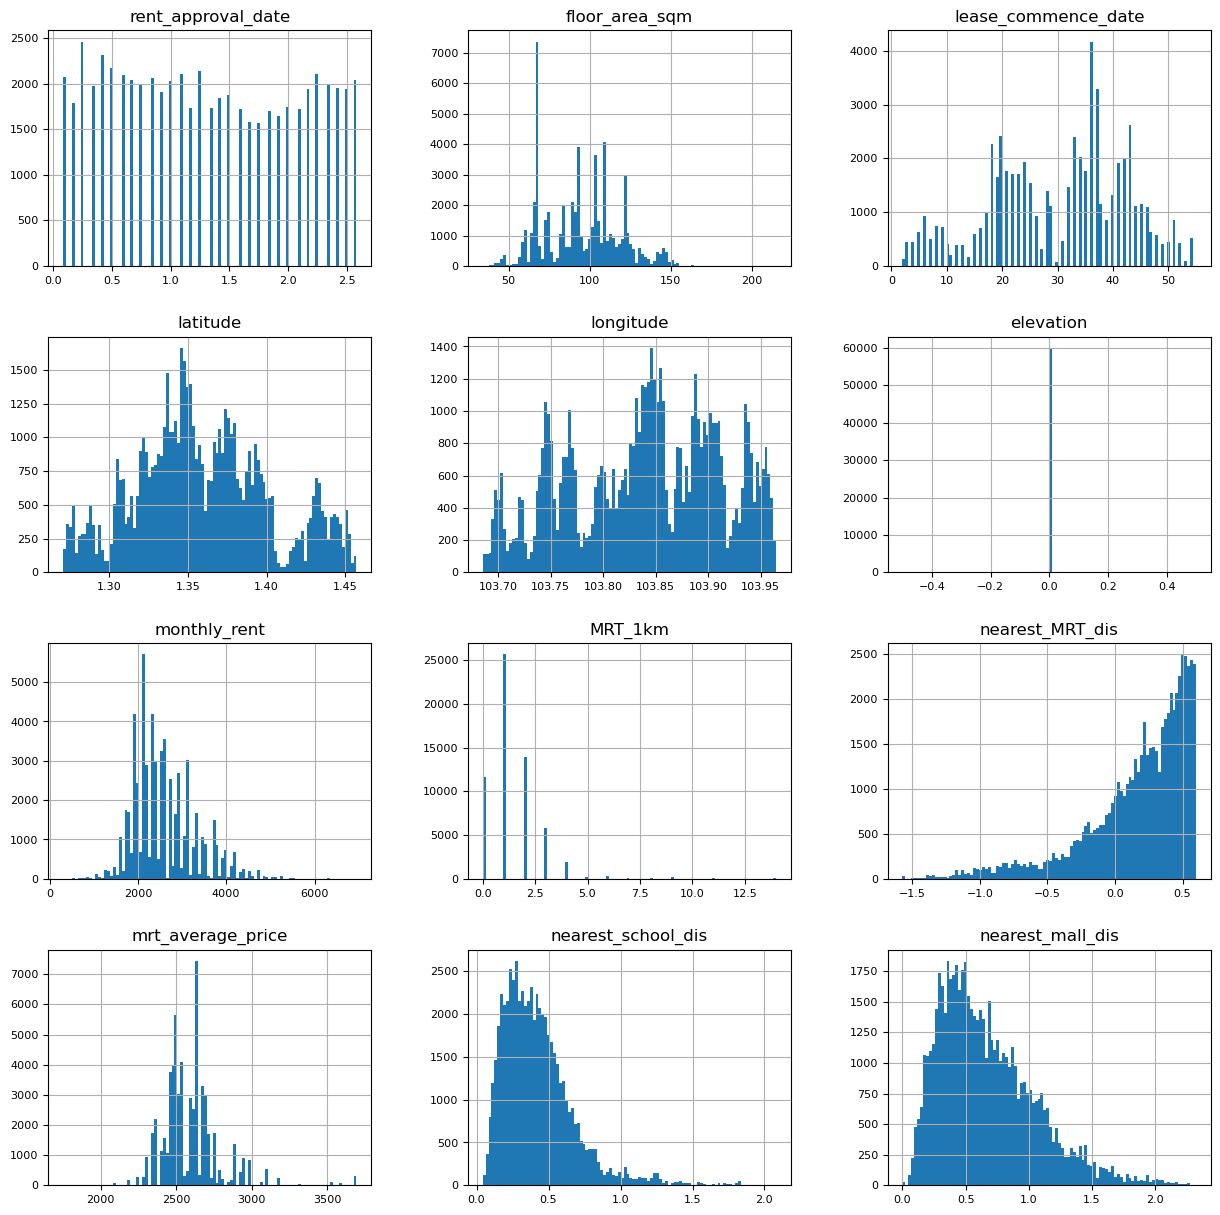

In [ ]:
X_train_num.hist(figsize=(15, 15), bins=100, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

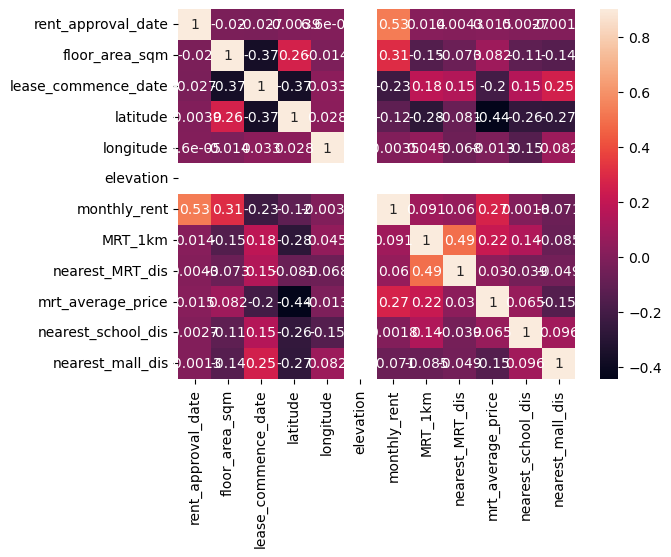

In [ ]:
corrmat = X_train_num.corr()
sns.heatmap(corrmat, vmax=.9, annot=True)

count    60000.000000
mean      2590.328333
std        714.910468
min        300.000000
25%       2100.000000
50%       2400.000000
75%       3000.000000
max       6950.000000
Name: monthly_rent, dtype: float64


<Figure size 640x480 with 0 Axes>

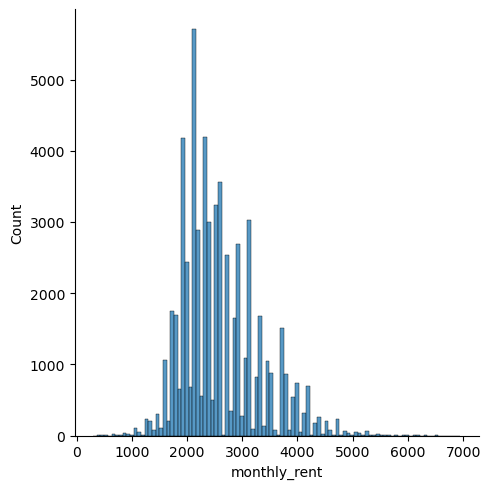

In [ ]:
y_train = train_data['monthly_rent']
print(y_train.describe())
plt.figure()
sns.displot(y_train, bins=100)

In [ ]:
def feature_engineering(data):
    # numerical feature
    data_num = data.select_dtypes(include = ['float64', 'int64'])
    data_num = data_num[['rent_approval_date', 'floor_area_sqm', 'lease_commence_date','mrt_average_price','MRT_1km', 'nearest_MRT_dis', 'nearest_school_dis']] # 'nearest_mall_dis'

    # categorical feature
    data_cat = data.select_dtypes(include = ['object'])
    data_cat_one_hot = pd.get_dummies(data[['region']]) #'flat_type' , 'planning_area', 'town', 'flat_model'

    data_cat_target = pd.DataFrame()

    # region_encoded = train_data.groupby('region')['monthly_rent'].mean()
    # data_cat_target['region_encoded'] = data['region'].map(region_encoded)
    
    town_encoded = train_data.groupby('town')['monthly_rent'].mean()
    data_cat_target['town_encoded'] = data['town'].map(town_encoded)
    
    planning_area_encoded = train_data.groupby('planning_area')['monthly_rent'].mean()
    data_cat_target['planning_area_encoded'] = data['planning_area'].map(planning_area_encoded)

    subzone_encoded = train_data.groupby('subzone')['monthly_rent'].mean()
    data_cat_target['subzone_encoded'] = data['subzone'].map(subzone_encoded)

    flat_model_encoded = train_data.groupby('flat_model')['monthly_rent'].mean()
    data_cat_target['flat_model_encoded'] = data['flat_model'].map(flat_model_encoded)

    flat_type_encoded = train_data.groupby('flat_type')['monthly_rent'].mean()
    data_cat_target['flat_type_encoded'] = data['flat_type'].map(flat_type_encoded)

    # block_encoded = train_data.groupby('block')['monthly_rent'].median().transform(lambda x: int(x / 1000) * 1000)
    # data_cat_target['block_encoded'] = data['block'].map(block_encoded)

    street_name_encoded = train_data.groupby('street_name')['monthly_rent'].mean()
    data_cat_target['street_name_encoded'] = data['street_name'].map(street_name_encoded)

    # nearest_mall_name_encoded = train_data.groupby('nearest_mall_name')['monthly_rent'].mean()
    # data_cat_target['nearest_mall_name_encoded'] = data['nearest_mall_name'].map(nearest_mall_name_encoded)

    # nearest_school_name_encoded = train_data.groupby('nearest_school_name')['monthly_rent'].mean()
    # data_cat_target['nearest_school_name_encoded'] = data['nearest_school_name'].map(nearest_school_name_encoded)

    # data_cat_target['town_encoded'] = train_data.groupby('town')['monthly_rent'].transform('mean')
    # data_cat_target['planning_area_encoded'] = train_data.groupby('planning_area')['monthly_rent'].transform('mean')
    # data_cat_target['block_encoded'] = train_data.groupby('block')['monthly_rent'].transform('mean')
    # data_cat_target['street_name_encoded'] = train_data.groupby('street_name')['monthly_rent'].transform('mean')

    # Concate all the choosed features
    # data_filter = pd.concat([data_num, data_cat_target], axis=1)
    data_filter = pd.concat([data_num, data_cat_one_hot, data_cat_target], axis=1)

    return data_filter

X_train = feature_engineering(train_data)
X_train
    

,rent_approval_date,floor_area_sqm,lease_commence_date,mrt_average_price,MRT_1km,nearest_MRT_dis,nearest_school_dis,region_central region,region_east region,region_north east region,region_north region,region_west region,town_encoded,planning_area_encoded,subzone_encoded,flat_model_encoded,flat_type_encoded,street_name_encoded
0,0.750000,67.0,38,2481.346424,1.0,0.200699,0.334495,0,0,0,0,1,2595.146199,2595.146199,2542.158516,2369.965462,2276.033233,2312.179487
1,1.416667,92.0,43,2425.980392,1.0,0.000923,0.605547,0,1,0,0,0,2438.227223,2438.227223,2360.371046,2369.965462,2692.359176,2404.212860
2,1.833333,67.0,50,2632.947462,4.0,0.518801,0.426187,1,0,0,0,0,2516.680515,2516.680515,2808.893871,2636.211052,2276.033233,2403.464419
3,0.666667,149.0,28,2687.550471,0.0,-0.647366,0.562392,0,1,0,0,0,2686.857477,2686.857477,2610.338573,2878.725962,2892.857143,2757.834101
4,1.916667,68.0,49,2589.985486,3.0,0.487930,0.271506,1,0,0,0,0,2665.537634,2702.635659,2793.525180,2636.211052,2276.033233,2395.744681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.750000,67.0,42,2461.518550,1.0,0.231013,0.361006,0,0,1,0,0,2416.700057,2416.700057,2390.887097,2369.965462,2276.033233,2336.012658
59996,2.333333,83.0,2,2881.436907,2.0,0.279747,0.562558,1,0,0,0,0,2904.113924,2904.113924,2694.936709,2612.031305,2692.359176,3400.000000
59997,1.500000,122.0,33,2643.672840,2.0,0.176264,0.318659,0,1,0,0,0,2638.489123,2638.489123,2602.823315,2636.211052,2815.593875,2509.600000
59998,2.083333,123.0,44,2425.980392,1.0,-0.018778,0.219191,0,1,0,0,0,2438.227223,2438.227223,2434.379786,2444.223986,2815.593875,2591.447368


## Start to train

### Training preparation

#### Train-Test Split

In [ ]:
X, y = X_train, y_train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Define evaluation metrics

In [ ]:
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
#     return rmse
          
metrics_dict = {'MAE': [], 'R2 Score': [], 'MSE': [], 'RMSE': []}#lykmod

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    r_squared = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))

    
    print("MAE:", mae)
    print("R2 Score:", r_squared)
    print("MSE:", mse)
    print("RMSE:", rmse)
    metrics_dict['MAE'].append(mae)
    metrics_dict['R2 Score'].append(r_squared)
    metrics_dict['MSE'].append(mse)
    metrics_dict['RMSE'].append(rmse)#lykmod


def plot_metrics():
    # 创建柱状图
    for metric, values in metrics_dict.items():
        plt.figure(figsize=(10, 10))
        plt.bar(range(len(values)), values)
        plt.title(metric)
        plt.show()
    

In [ ]:
plot_metrics()

### Linear Models

#### Linear Regression(Ordinary Least Squares)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

evaluation(y_test, predictions)

#### Ridge Regression

In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

evaluation(y_test, predictions)

#### Lasso Regression

In [ ]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

evaluation(y_test, predictions)

#### Elastic-Net Regression

In [ ]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

evaluation(y_test, predictions)

#### Stochastic Gradient Descent - SGD

In [ ]:
scaler = StandardScaler()
X_train_sgd = scaler.fit_transform(X_train)
X_test_sgd = scaler.transform(X_test)

sgd = SGDRegressor(loss="epsilon_insensitive")
sgd.fit(X_train_sgd, y_train)
predictions = sgd.predict(X_test_sgd)

evaluation(y_test, predictions)

#### Polynomial regression

In [ ]:
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

evaluation(y_test, predictions)

### Support Vector Machines

#### Support Vector Regression

In [ ]:
svr = SVR(C=200000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

evaluation(y_test, predictions)

### Nearest Neighbors

#### Nearest Neighbors Regression

In [ ]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=20)
knn_reg.fit(X_train_nn, y_train)
predictions = knn_reg.predict(X_test_nn)

evaluation(y_test, predictions)

### Decision Tree

#### DecisionTreeRegressor

In [75]:
tree_reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50)
tree_reg.fit(X_train, y_train)
predictions = tree_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 377.6048445592698
R2 Score: 0.5055777772918002
MSE: 249424.12832159884
RMSE: 499.4237963109075


#### Gradient Boosting Decision Tree

In [79]:
from sklearn.ensemble import GradientBoostingRegressor

gbdt_reg = GradientBoostingRegressor()
gbdt_reg.fit(X_train, y_train)
predictions = gbdt_reg.predict(X_test)
evaluation(y_test, predictions)


MAE: 367.6745376701962
R2 Score: 0.5352786542831184
MSE: 234440.74971582217
RMSE: 484.19081952864633


### Ensemble Methods

#### catboost

In [82]:
from catboost import CatBoostRegressor

cat_reg = CatBoostRegressor()
cat_reg.fit(X_train, y_train)
predictions = cat_reg.predict(X_test)
evaluation(y_test, predictions)

Learning rate set to 0.075477
0:	learn: 691.6976647	total: 63.9ms	remaining: 1m 3s
1:	learn: 670.0862617	total: 67.4ms	remaining: 33.6s
2:	learn: 651.5977470	total: 70.3ms	remaining: 23.4s
3:	learn: 634.3181300	total: 73.6ms	remaining: 18.3s
4:	learn: 618.6389643	total: 76.9ms	remaining: 15.3s
5:	learn: 604.2872655	total: 80ms	remaining: 13.2s
6:	learn: 591.9545024	total: 83.8ms	remaining: 11.9s
7:	learn: 581.4525303	total: 86.7ms	remaining: 10.8s
8:	learn: 571.6240751	total: 90.6ms	remaining: 9.97s
9:	learn: 563.1650314	total: 93.6ms	remaining: 9.27s
10:	learn: 555.5604778	total: 99.4ms	remaining: 8.94s
11:	learn: 548.9682647	total: 103ms	remaining: 8.48s
12:	learn: 542.8453633	total: 106ms	remaining: 8.05s
13:	learn: 537.2763569	total: 109ms	remaining: 7.65s
14:	learn: 532.4722182	total: 112ms	remaining: 7.36s
15:	learn: 528.3281466	total: 115ms	remaining: 7.09s
16:	learn: 524.6627028	total: 119ms	remaining: 6.85s
17:	learn: 521.3006084	total: 122ms	remaining: 6.64s
18:	learn: 518.04

#### Gradient-boosted trees

In [80]:
hist_reg = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01)
hist_reg.fit(X_train, y_train)
predictions = hist_reg.predict(X_test)

evaluation(y_test, predictions)

MAE: 364.5392333771496
R2 Score: 0.5407092885538625
MSE: 231701.12524709522
RMSE: 481.3534307004524


#### Random Forest

In [ ]:
random_forest = RandomForestRegressor(n_estimators=1200,max_depth=15,min_samples_split=5,min_samples_leaf=5,max_features=None,oob_score=True)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

evaluation(y_test, predictions)

#lykmod


In [ ]:
#lykmod

# 
importances = random_forest.feature_importances_

#
features = X_train.columns

#
feature_importances = dict(zip(features, importances))

# 
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f'Feature: {feature}, Importance: {importance}')

#
plt.figure(figsize=(50, 20))

#
labels, values = zip(*feature_importances)


plt.bar(labels, values)


plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

# 
plt.show()

#### BaggingRegressor

In [ ]:
bag_reg = BaggingRegressor(n_estimators=100)
bag_reg.fit(X_train, y_train)
predictions = bag_reg.predict(X_test)

evaluation(y_test, predictions)

#### AdaBoost Regressor

In [ ]:
base_reg = LinearRegression()
ada_reg = AdaBoostRegressor(base_estimator=base_reg, n_estimators=1000)
ada_reg.fit(X_train, y_train)
predictions = ada_reg.predict(X_test)

evaluation(y_test, predictions)

#### XGBoost Regressor

In [ ]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

evaluation(y_test, predictions)

MAE: 363.92760832214356
R2 Score: 0.5409329785688874
MSE: 231588.27901072215
RMSE: 481.236198774284


#### Voting Regressor(Blend different regressors)

In [ ]:
voting_reg = VotingRegressor(estimators=[('hist', hist_reg), ('xgb', xgb)])
voting_reg.fit(X_train, y_train)
predictions = voting_reg.predict(X_test)

evaluation(y_test, predictions)


### Neural network models (supervised)

#### MLP Regressor

In [73]:
mlp_reg = MLPRegressor(learning_rate='adaptive')
mlp_reg.fit(X_train, y_train)
predictions = mlp_reg.predict(X_test)
print(predictions)
print(predictions.shape)
y_test_np = y_test.values
print(y_test)
print(y_test_np.shape)
print(y_test_np)

evaluation(y_test_np, predictions)

[1829.17547256 2569.30544155 2094.51889101 ... 2871.8236414  1773.3685151
 2257.51695685]
(12000,)
12628    1750
37730    2200
39991    1650
8525     1600
8279     2250
         ... 
49914    3150
34428    2200
45810    3450
30357    1600
36568    2050
Name: monthly_rent, Length: 12000, dtype: int64
(12000,)
[1750 2200 1650 ... 3450 1600 2050]
MAE: 407.4703688091806
R2 Score: 0.4640103528406697
MSE: 270393.89491806534
RMSE: 519.994129695774


#### NN

In [ ]:



class DeepDNNModel(nn.Module):
    def __init__(self):
        super(DeepDNNModel, self).__init__()
        self.layer1 = nn.Linear(18, 128)  #
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 1024)
        self.layer5 = nn.Linear(1024, 512)
        self.layer6 = nn.Linear(512, 256)
        self.layer7 = nn.Linear(256, 128)
        self.layer8 = nn.Linear(128, 64)
        self.layer9 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.2)
        self.layer10 = nn.Linear(32, 1)


    def forward(self, x):
        x = torch.relu((self.layer1(x)))
        x = torch.relu((self.layer2(x)))
        x = torch.relu((self.layer3(x)))
        x = torch.relu((self.layer4(x)))
        x = torch.relu((self.layer5(x)))
        x = torch.relu((self.layer6(x)))
        x = torch.relu((self.layer7(x)))
        x = torch.relu((self.layer8(x)))
        x = torch.relu((self.layer9(x)))
        x = self.dropout(x)
        x = self.layer10(x)  # 
        return x

# 
deep_dnn_model = DeepDNNModel()


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(deep_dnn_model.parameters() )

# 将DataFrame转换为Tensor
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
print(X_train_tensor.shape)
print(y_train_tensor.shape)
y_train_tensor = y_train_tensor.unsqueeze(1)
print(y_train_tensor.shape)
print(y_train_tensor)
print(X_test_tensor.shape)

# 
for epoch in range(300):  
    optimizer.zero_grad()  
    outputs = deep_dnn_model(X_train_tensor) 
    #print(outputs.shape)
    loss = criterion(outputs, y_train_tensor) 
    loss.backward() 
    optimizer.step() 


predictions = deep_dnn_model(X_test_tensor)
print(predictions.shape)
print(predictions)

# 将Tensor转numpy
predictions_np = predictions.detach().numpy().squeeze()
print(predictions_np.shape)
print(predictions_np)
y_test_np = y_test.values
print(y_test_np.shape)
print(y_test_np)

# 
evaluation(y_test_np, predictions_np)


### Blend methods

In [83]:
def blended_pred(x):
    return 0.6 * xgb.predict(x) + 0.4 * hist_reg.predict(x) # + 0.05 * ada_reg.predict(x)


evaluation(y_test, blended_pred(X_test))

MAE: 363.81445332568813
R2 Score: 0.5416985666522908
MSE: 231202.05822293003
RMSE: 480.83475147178166


## Predict on test data

Predicet test dataset

In [ ]:
test_data = data_preprocessing(test_data)
test_data = feature_engineering(test_data)

test_data

In [ ]:
test_data = test_data.reindex(columns=X_train.columns, fill_value=False)

test_data

In [ ]:
# best_model = voting_reg
# test_pred = best_model.predict(test_data)

test_pred = blended_pred(test_data)
test_pred

In [ ]:
sample_submission_path = './Datasets/example-submission.csv'
sample_submission_df = pd.read_csv(sample_submission_path)
sample_submission_df['Predicted'] = test_pred
sample_submission_df.to_csv('./Datasets/submission.csv', index=False)
sample_submission_df.head()